## Installing and importing the libraries

In [ ]:
!pip3 install opencv-python matplotlib tensorflow==2.14.0 

In [30]:
#Importing the necessary libraries
import cv2
from matplotlib import pyplot as plot
from sklearn.model_selection import train_test_split
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
import glob
import os
from keras.metrics import binary_accuracy
# from keras.backend import tf
from keras.losses import binary_crossentropy
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
# from tensorflow.keras.optimizers import Adam

## Download dataset from S3 Bucket and Sorting it

In [32]:
# import boto3

# s3 = boto3.client('s3')
# l1= [img_path.split('/')[-1] for img_path in fs.ls('s3://{bucket-name}/{data_dir}/') if img_path.endswith('.png')]
# for file in l1:
#     print(file)
#     s3.download_file('bucket-name', 'data_dir/{}'.format(file), '{}'.format(file))

In [33]:
normal= [os.path.join('./dataset/normal',img_path) for img_path in os.listdir('./dataset/normal/') if img_path.endswith(').png')]
normal_masks = [os.path.join('./dataset/normal',img_path) for img_path in os.listdir('./dataset/normal/') if img_path.endswith('_mask.png')]

benign = [os.path.join('./dataset/benign',img_path) for img_path in os.listdir('./dataset/benign') if img_path.endswith(').png')]
benign_masks = [os.path.join('./dataset/benign',img_path) for img_path in os.listdir('./dataset/benign') if img_path.endswith('_mask.png')]

malignant = [os.path.join('./dataset/malignant',img_path) for img_path in os.listdir('./dataset/malignant') if img_path.endswith(').png')]
malignant_masks = [os.path.join('./dataset/malignant',img_path) for img_path in os.listdir('./dataset/malignant') if img_path.endswith('_mask.png')]

normal.sort(reverse=True)
normal_masks.sort(reverse=True)

benign.sort(reverse=True)
benign_masks.sort(reverse=True)

malignant.sort(reverse=True)
malignant_masks.sort(reverse=True)

In [34]:
for i in malignant_masks:
  if  'mask_' in str(i):
    malignant_masks.remove(i)


for i in benign_masks:
  if  'mask_' in str(i):
    benign_masks.remove(i)

benign_masks.remove(benign_masks[330])



print(len(malignant),len(malignant_masks))
print(len(benign),len(benign_masks))
print(len(normal), len(normal_masks))

210 210
437 436
133 133


## Data Preprocessing

In [35]:
def binarize(matrix):
    matrix = np.round(matrix/255)*255
    return matrix

In [ ]:
images = []
target = []

for i in range(210):
    print(malignant[i])
    try:
      m = cv2.cvtColor(cv2.resize(cv2.imread(r'{}'.format(malignant[i])),(224,224)),cv2.COLOR_BGR2GRAY)
      mm = cv2.cvtColor(cv2.resize(cv2.imread(r'{}'.format(malignant_masks[i])),(224,224)),cv2.COLOR_BGR2GRAY)
      images.append(m)
      target.append(binarize(mm))
    except Exception as e:
      print(e)
      continue

for i in range(437):
    print(benign[i])
    try:
      b = cv2.cvtColor(cv2.resize(cv2.imread(r'{}'.format(benign[i])),(224,224)),cv2.COLOR_BGR2GRAY)
      bm = cv2.cvtColor(cv2.resize(cv2.imread(r'{}'.format(benign_masks[i])),(224,224)),cv2.COLOR_BGR2GRAY)
      images.append(b)
      target.append(binarize(bm))
    except Exception as e:
      print(e)
      continue

for i in range(133):
    print(normal[i])
    try:
      n = cv2.cvtColor(cv2.resize(cv2.imread(r'{}'.format(normal[i])),(224,224)),cv2.COLOR_BGR2GRAY)
      nm = cv2.cvtColor(cv2.resize(cv2.imread(r'{}'.format(normal_masks[i])),(224,224)),cv2.COLOR_BGR2GRAY)
      images.append(n)
      target.append(binarize(nm))
    except Exception as e:
      print(e)
      continue


In [37]:
x = np.array(images)
x = x / 255
y = np.array(target)
y = y / 255

In [38]:
len(y)

779

In [39]:
x.shape

(779, 224, 224)

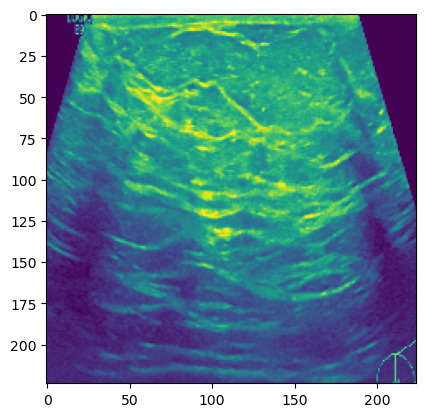

In [40]:
plot.imshow(x[19])

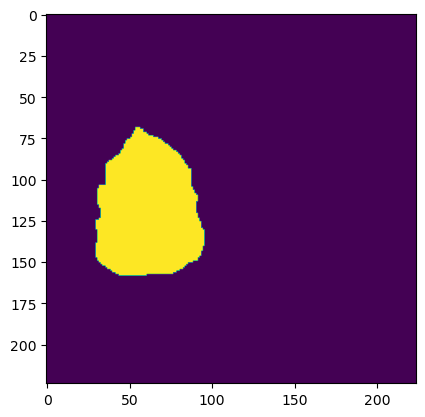

In [41]:
plot.imshow(y[19])

## Splitting Data into Train, Test and Val

In [42]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2)

In [43]:
print("Training set shape: ")
print(X_train.shape)
print(y_train.shape)
print("Validation set shape: ")
print(X_val.shape)
print(y_val.shape)
print("Test set shape: ")
print(X_test.shape)
print(y_test.shape)

Training set shape: 
(498, 224, 224)
(498, 224, 224)
Validation set shape: 
(125, 224, 224)
(125, 224, 224)
Test set shape: 
(156, 224, 224)
(156, 224, 224)


## Define evaluation metrics

In [44]:
def dice_metric(y_true, y_pred):
  y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
  y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
  # print("y_true_f.shape: ",y_true_f.shape)
  # print("y_pred_f.shape: ",y_pred_f.shape)
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

def accuracy(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    return binary_accuracy(y_true_f, y_pred_f)

def precision(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true_f * y_pred_f, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred_f, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true_f * y_pred_f, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true_f, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def f1_score(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    prec = precision(y_true_f, y_pred_f)
    rec = recall(y_true_f, y_pred_f)
    f1 = 2*((prec*rec)/(prec+rec+tf.keras.backend.epsilon()))
    return f1


## Train, evaluate and save model

In [45]:
inputs = keras.layers.Input((224,224,1))
print('read inputs')
# Convolution + Max Pooling

conv1 = keras.layers.Conv2D(32,2,padding='same',activation='relu')(inputs)
conv11 = keras.layers.Conv2D(32,2,padding='same',activation='relu')(conv1)
pool1 = keras.layers.MaxPool2D((2,2))(conv11)
print('Convolution + Max Pooling 1')

# Convolution + Max Pooling
conv2 =  keras.layers.Conv2D(64,3,padding='same',activation='relu')(pool1)
conv21 =  keras.layers.Conv2D(64,3,padding='same',activation='relu')(conv2)
pool2 = keras.layers.MaxPool2D((2,2))(conv21)
print('Convolution + Max Pooling 2')

# Convolution + Max Pooling
conv3 =  keras.layers.Conv2D(128,3,padding='same',activation='relu')(pool2)
conv31 =  keras.layers.Conv2D(128,3,padding='same',activation='relu')(conv3)
pool3 = keras.layers.MaxPool2D((2,2))(conv31)
print('Convolution + Max Pooling 3')

conv4 =  keras.layers.Conv2D(256,3,padding='same',activation='relu')(pool3)
conv41 =  keras.layers.Conv2D(256,3,padding='same',activation='relu')(conv4)
pool4 = keras.layers.MaxPool2D((2,2))(conv41)
print('Convolution + Max Pooling 4')

upsample2 = keras.layers.UpSampling2D((2,2))(pool4)
print('Upsample')

#end
uconv2 =  keras.layers.Conv2D(256,3,padding='same',activation='relu')(upsample2)
merge2 = keras.layers.Concatenate()([conv41,uconv2])
uconv21 =  keras.layers.Conv2D(256,3,padding='same',activation='relu')(merge2)
print('Cov Merge 1')

upsample3 = keras.layers.UpSampling2D((2,2))(uconv21)

uconv3 =  keras.layers.Conv2D(128,3,padding='same',activation='relu')(upsample3)
merge3 = keras.layers.Concatenate()([conv31,uconv3])
uconv31 =  keras.layers.Conv2D(128,3,padding='same',activation='relu')(merge3)
print('Cov Merge 2')

upsample4 = keras.layers.UpSampling2D((2,2))(uconv31)

uconv4=  keras.layers.Conv2D(64,3,padding='same',activation='relu')(upsample4)
merge4 = keras.layers.Concatenate()([conv21,uconv4])
uconv41 =  keras.layers.Conv2D(64,3,padding='same',activation='relu')(merge4)
print('Cov Merge 3')

upsample5 = keras.layers.UpSampling2D((2,2))(uconv41)

uconv5=  keras.layers.Conv2D(32,3,padding='same',activation='relu')(upsample5)
merge5 = keras.layers.Concatenate()([conv11,uconv5])
uconv51 =  keras.layers.Conv2D(32,3,padding='same',activation='relu')(merge5)
print('Cov Merge 4')

output =  keras.layers.Conv2D(1,1,padding='same',activation='sigmoid')(uconv51)
print('read outputs')
unet = keras.models.Model(inputs=inputs,outputs=output)
unet.summary()
print('model init')
unet.compile(
    optimizer = keras.optimizers.Adam(learning_rate=1e-3) ,
    metrics = [dice_metric, accuracy, precision, recall, f1_score],
    loss='binary_focal_crossentropy')
print('model compiled')

print(X_train.shape)
print(y_train.shape)
early_stopping=keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)
unet.fit(X_train, y_train, epochs=150 ,validation_data=(X_test,y_test), callbacks=[early_stopping])

print('model trained')

read inputs
Convolution + Max Pooling 1
Convolution + Max Pooling 2
Convolution + Max Pooling 3
Convolution + Max Pooling 4
Upsample
Cov Merge 1
Cov Merge 2
Cov Merge 3
Cov Merge 4
read outputs
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d_68 (Conv2D)          (None, 224, 224, 32)         160       ['input_5[0][0]']             
                                                                                                  
 conv2d_69 (Conv2D)          (None, 224, 224, 32)         4128      ['conv2d_68[0][0]']           
                                                                                                

In [46]:
unet.evaluate(X_val, y_val)

4/4 [==============================] - 0s 106ms/step - loss: 0.1924 - dice_metric: 0.4928 - accuracy: 0.9428 - precision: 0.5825 - recall: 0.4932 - f1_score: 0.5306


[0.19241197407245636,
 0.49282145500183105,
 0.9427524209022522,
 0.5824692249298096,
 0.4931519329547882,
 0.5306313037872314]

In [47]:
unet.save('./breast_cancer_unet_cnn.keras')

## Model Inference

1/1 [==============================] - 0s 20ms/step


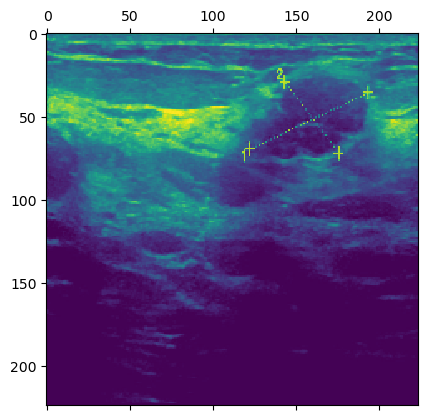

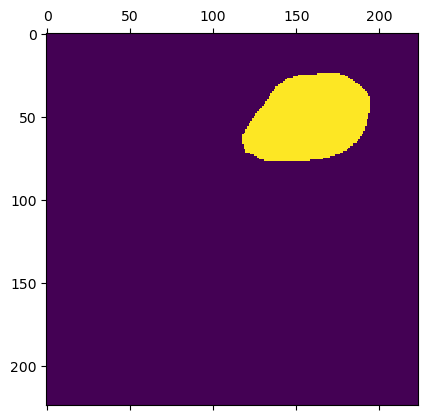

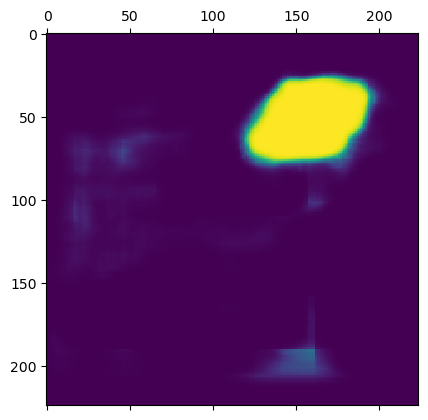

In [51]:
def model_inference(index,categorical=True):
  plot.matshow(X_val[index])
  yp = unet.predict(X_val[index].reshape(1,224,224))
  plot.matshow(y_val[index])
  plot.matshow(yp.reshape(224,224))


model_inference(55)

1/1 [==============================] - 0s 20ms/step


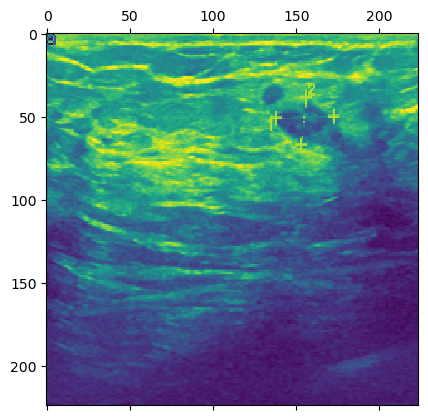

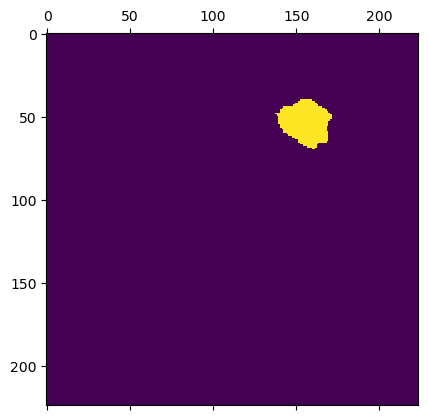

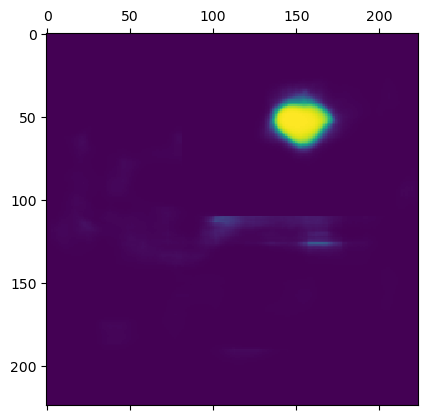

In [52]:
model_inference(99)

1/1 [==============================] - 0s 20ms/step


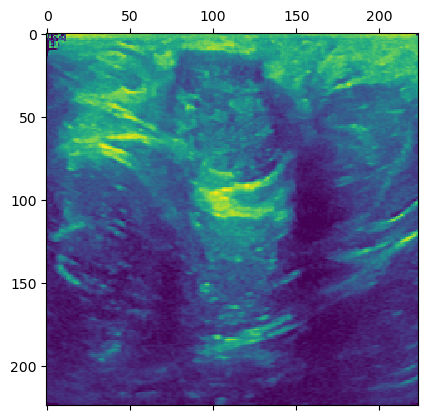

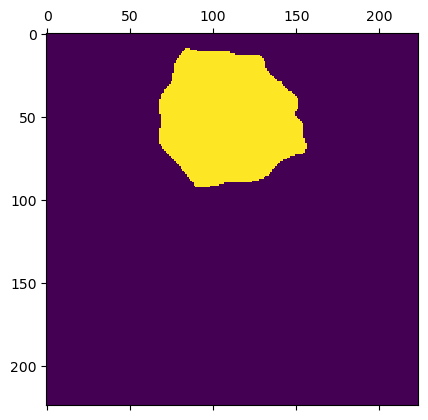

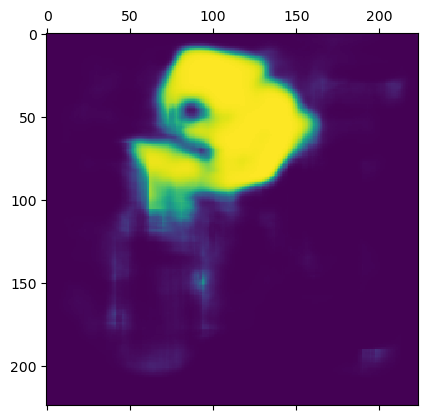

In [53]:
model_inference(30)

1/1 [==============================] - 0s 20ms/step


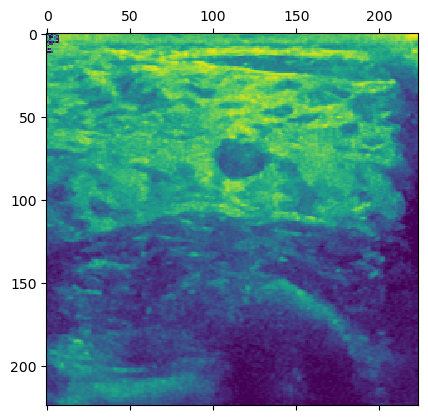

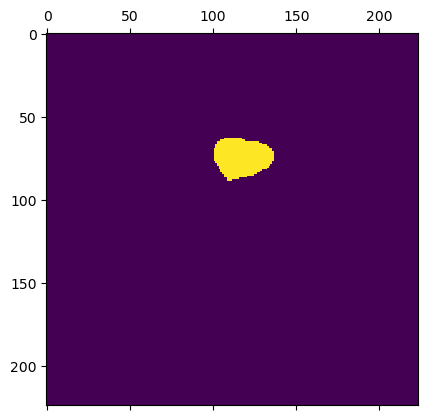

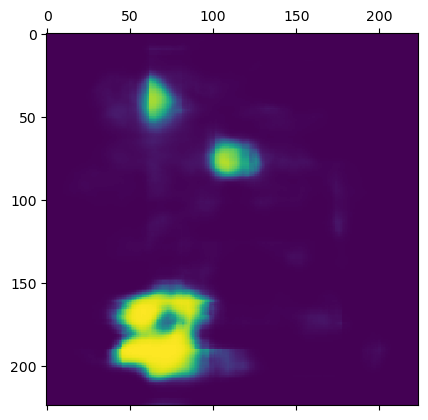

In [55]:
model_inference(45)